In [137]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from jax import jit

In [138]:
data = pd.read_csv('/Users/liibanmohamud/Desktop/scikit-jax/examples/data/clustering_data/basic5.csv')

In [139]:
data.head()

,x,y,color
0,472.431845,133.637138,1
1,392.213650,248.151058,1
2,185.231588,128.911761,0
3,175.553180,234.373421,0
4,199.902134,373.492265,2


In [140]:
X = data.drop(columns='color').to_numpy()
y = data['color'].to_numpy()

X, y = map(
    jnp.asarray,
    (X, y)
)

unique_classes = jnp.unique(y)

unique_classes

Array([0, 1, 2], dtype=int32)

In [141]:
def split_data(data, val_size=0.1, test_size=0.2):
    """ 
    Splits data.
    """
    split_index_test = int(len(data) * (1-test_size))

    data_non_test = data[:split_index_test]
    data_test = data[split_index_test:]

    split_index_val = int(len(data_non_test) * (1-val_size))

    data_train = data_non_test[:split_index_val]
    data_val = data_non_test[split_index_val:]

    return data_train, data_val, data_test

In [142]:
(X_train, X_val, X_test), (y_train, y_val, y_test) = split_data(X), split_data(y)

In [143]:
def compute_euclidean_distance(x1, x2):
    return jnp.sqrt(jnp.sum((x1 - x2)**2))

In [144]:
centroids = X[np.random.choice(len(X), size=2)]
[[compute_euclidean_distance(centroid, x) for x in X] for centroid in centroids]

[[Array(271.7591, dtype=float32),
  Array(202.87802, dtype=float32),
  Array(48.150623, dtype=float32),
  Array(67.09597, dtype=float32),
  Array(200.10558, dtype=float32),
  Array(47.415394, dtype=float32),
  Array(242.50787, dtype=float32),
  Array(234.56421, dtype=float32),
  Array(242.01465, dtype=float32),
  Array(45.534317, dtype=float32),
  Array(181.3904, dtype=float32),
  Array(48.806816, dtype=float32),
  Array(263.0237, dtype=float32),
  Array(28.357359, dtype=float32),
  Array(53.169968, dtype=float32),
  Array(193.39545, dtype=float32),
  Array(16.10628, dtype=float32),
  Array(214.62599, dtype=float32),
  Array(262.41058, dtype=float32),
  Array(127.044266, dtype=float32),
  Array(246.57986, dtype=float32),
  Array(209.00981, dtype=float32),
  Array(237.93169, dtype=float32),
  Array(246.68097, dtype=float32),
  Array(227.38405, dtype=float32),
  Array(230.14249, dtype=float32),
  Array(212.67097, dtype=float32),
  Array(32.65741, dtype=float32),
  Array(199.61827, dtype=

In [145]:
def kmeans_plus_initialization(key:jax.Array, num_clusters:int, X:jax.Array):

    indices_of_available_centroids = np.arange(len(X)) # Used to keep track which centroid has been chosen.

    key, subkey = jax.random.split(key)

    init_index = jax.random.choice(key, indices_of_available_centroids)
    init_centroids = [X[init_index]]
    indices_of_available_centroids = np.delete(indices_of_available_centroids, init_index)

    index = 0
    while len(init_centroids) < num_clusters:
        distance_between_points_and_init_centroid = jnp.asarray([compute_euclidean_distance(init_centroids[index], x) for x in X])
        # Computing probabilities of choosing centroids proportional to distance
        probabilities = distance_between_points_and_init_centroid[indices_of_available_centroids] / jnp.sum(distance_between_points_and_init_centroid[indices_of_available_centroids])
        index_of_centroid_chosen = jax.random.choice(subkey, indices_of_available_centroids, p=probabilities, replace=False)
        init_centroids.append(X[index_of_centroid_chosen])
        indices_of_available_centroids = jnp.delete(indices_of_available_centroids, index_of_centroid_chosen)
        index += 1

    return jnp.asarray(init_centroids)

In [146]:
centroids

Array([[203.60059, 173.42088],
       [469.42822, 180.05449]], dtype=float32)

In [147]:
def initialize_k_centroids(num_clusters, X, init:str='random', seed:int=12):
    key = jax.random.key(seed)
    initialization = {
        'random': jax.random.choice(key, X, shape=(num_clusters,), replace=False),
        'k-means++': kmeans_plus_initialization(key, num_clusters, X)
    }
    return initialization[init]

In [148]:
centroids = initialize_k_centroids(3, X, init='k-means++')

In [149]:
def calculating_distances_between_centroids_and_points(centroids, X):
    return jnp.asarray([[compute_euclidean_distance(centroid, x) for x in X] for centroid in centroids])

In [150]:
def calculate_new_centroids(centroids, X):
    distances_between_centroids_and_points = calculating_distances_between_centroids_and_points(centroids, X)
    labels_of_each_point = jnp.argmin(distances_between_centroids_and_points.T, axis=1)
    indices_of_each_cluster = [jnp.where(labels_of_each_point == label) for label in jnp.unique(labels_of_each_point)]
    new_centroids = jnp.asarray([jnp.mean(X[collection_of_indices].T, axis=1) for collection_of_indices in indices_of_each_cluster])
    return new_centroids

In [151]:
distances_between_centroids_and_points = calculating_distances_between_centroids_and_points(centroids, X)
labels_of_each_point = jnp.argmin(distances_between_centroids_and_points.T, axis=1)
indices_of_each_cluster = [jnp.where(labels_of_each_point == label) for label in jnp.unique(labels_of_each_point)]
jnp.std(X[indices_of_each_cluster[2]])
jnp.unique(labels_of_each_point).shape

(3,)

In [152]:
@jit
def calculate_stds_in_each_cluster(centroids, X, num_of_unique_classes=3):
    distances_between_centroids_and_points = calculating_distances_between_centroids_and_points(centroids, X)
    labels_of_each_point = jnp.argmin(distances_between_centroids_and_points.T, axis=1)

    def compute_std_for_label(label):
        collection_of_indices = jnp.where(labels_of_each_point == label)
        return jnp.std(X[collection_of_indices])

    total_std_for_each_label = jnp.zeros_like(unique_classes)

    for label_index, label in zip(total_std_for_each_label, unique_classes):
        total_std_for_each_label.at[label_index].set(compute_std_for_label(label))

    return jnp.sum(total_std_for_each_label)

In [153]:
def fit(centroids, X_train, epochs:int=20, max_patience=3):
    best_std = jnp.inf
    patience = 0

    for epoch in range(epochs):
        centroids = calculate_new_centroids(centroids, X_train)
        current_std = calculate_stds_in_each_cluster(centroids, X_train)
        print(f'Current std: {current_std}')
        if current_std < best_std:
            best_centroids = centroids
            print('Yes!')
            best_std = current_std
            patience = 0
        else:
            patience +=1

        if max_patience is None:
            continue

        if patience >= max_patience:
            print(f'Terminated at epoch:{epoch}')
            break
        print('------------------------------------------------------')

    return best_centroids

In [154]:
best_centroids = fit(centroids, X_train)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function calculate_stds_in_each_cluster at /var/folders/46/mr22f5ns5353zbl6w0klkkjc0000gn/T/ipykernel_3396/2712123663.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments centroids and X.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
best_centroids.T[0]

Array([184.7266 , 441.3487 , 285.46964], dtype=float32)

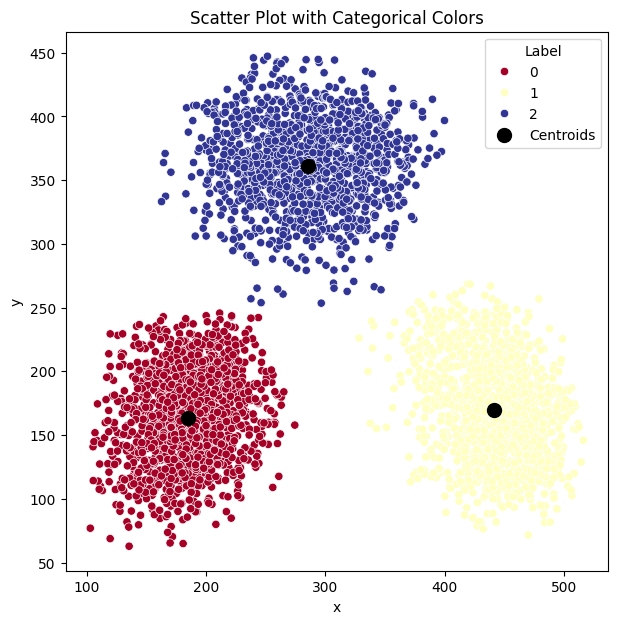

In [ ]:
plt.figure(figsize=(7,7))
palette = sns.color_palette('RdYlBu', as_cmap=True)

sns.scatterplot(data=data, x='x', y='y', hue='color', palette=palette, legend='full')
plt.scatter(best_centroids.T[0], best_centroids.T[1], color='black', s=100, label='Centroids')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot with Categorical Colors')
plt.legend(title='Label')

plt.show()

In [ ]:
class KMeansModel():
    def __init__(self, num_clusters:int, epochs:int=25, init:str='random', max_patience:int=5,seed:int=12):
        self.num_clusters = num_clusters 
        self.epochs = epochs
        self.max_patience = max_patience
        self.init = init
        self.seed = seed
        self.centroids = None

    def fit(self, X):
        best_std = jnp.inf
        patience = 0 
        centroids = initialize_k_centroids(num_clusters=self.num_clusters,
                                                X=X,
                                                init=self.init,
                                                seed=self.seed)

        print('Training model...')
        for epoch in range(self.epochs):
            centroids = calculate_new_centroids(centroids, X)
            current_std = calculate_stds_in_each_cluster(centroids, X)
            
            if current_std < best_std:
                self.centroids = centroids
                best_std = current_std
                patience = 0 
            else:
                patience +=1 

            if self.max_patience is None:
                continue

            if patience >= self.max_patience:
                print(f'Terminated at epoch:{epoch}')
                break

        return self
    
    def predict(self, X:jax.Array):
        distances_between_centroids_and_points = calculating_distances_between_centroids_and_points(self.centroids, X)
        print(f'Distances: {distances_between_centroids_and_points} \nShape = {jnp.asarray(distances_between_centroids_and_points).shape}')
        y_pred =  jnp.argmin(distances_between_centroids_and_points, axis=0)
        return y_pred

    def score(self, X:jax.Array, y:jax.Array):
        return jnp.mean(jnp.where(self.predict(X) == y, 1, 0))

In [ ]:
model2 = KMeansModel(num_clusters=3, init='k-means++')
model2_fitted = model2.fit(X_train)

Training model...
Terminated at epoch:5


In [ ]:
best_centroids3 = model2_fitted.centroids
best_centroids3, best_centroids

(Array([[286.28192, 362.56335],
        [441.3487 , 169.97482],
        [185.21455, 164.74278]], dtype=float32),
 Array([[184.7266 , 163.77151],
        [441.3487 , 169.97482],
        [285.46964, 360.98972]], dtype=float32))

In [ ]:
model2_fitted.score(X_test, y_test)

Distances: [[254.39746  219.79025  266.46887  ... 189.93858   58.86604   88.44757 ]
 [ 26.26658   42.13331   28.809334 ... 238.32372  260.68414  282.5099  ]
 [280.24756  265.23355  251.30649  ...  32.586575 278.85226  309.67935 ]] 
Shape = (3, 800)


Array(0.33625, dtype=float32)

In [ ]:
y_pred = model2_fitted.predict(X_val)

y_pred, y_val

Distances: [[ 16.575134  197.02786    50.618725  245.42764    82.1133    192.64296
  267.68118   173.09038   277.12943    43.50806   309.6514    104.372475
  236.06642    30.070772  211.59041   309.3222    177.55444    72.19045
  249.72423   301.2483    184.80908    75.82437   252.65198   202.56624
  267.7742     39.194912   43.090904  243.73143   237.89496   244.64833
  185.15816   264.24603   293.6636     60.56197    44.99766    32.934975
  294.46506    24.410624  237.29904   195.81906   310.3648     15.587728
  207.89146   178.97592   228.87546   106.61954   220.09445    65.726456
   63.54492   212.65448   339.49918   266.91946   300.84686   226.29163
  234.92488   305.23273   227.00378    57.52038   273.7377    270.72153
  253.03665   218.61981   226.8399    262.69257    57.909832   34.49392
   32.97875   292.56238    59.288174   56.456776   75.55648   275.50333
  200.81975   296.9623    314.42505   192.21696   277.95245   224.993
  255.37129    92.34841   309.5271     65.5292    2

(Array([0, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0,
        1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 2, 2, 1, 0, 2, 1,
        2, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0,
        0, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2,
        0, 2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 1, 1, 2,
        2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 2, 0, 0, 0, 2, 1, 2, 1, 2, 2, 2, 0,
        0, 1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1,
        2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0,
        1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 0, 2, 2, 1,
        2, 1, 0, 1, 2, 1, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 1, 2,
        1, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2,
        1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 

In [ ]:
from skjax.clustering import KMeans

In [ ]:
KMeans(num_clusters=2)